## **Содержание**
1. Что такое кросс-валидация модели, зачем она нужна
2. Виды кросс-валидации
3. Имплементация k-Fold
4. Тестирование на датасете и сравнение с готовой реализацией из sklearn
5. Что такое Grid Search и подбор гиперпараметров, зачем он нужен
6. Виды подбора гиперпараметров, Grid Search
7. Имплементация Grid Search
8. Имплементация Grid Search + CV (cross validation)
9. Тестирование на датасете и сравнение с готовой реализацией в sklearn

## **Что такое валидация модели, зачем она нужна**

После того, как мы обучили модель нам необходимо узнать прежде чем отправлять её в продакшн, хорошо ли она работает на новых данных, стабильно ли. ЗА оценку качества модели как раз и отвечает кросс-валидация. Кроме того, кросс-валидация позволяет сравнимать между собой модели и выбирать лучшую.

## **Виды кросс-валидации**

Есть несколько основных видов кросс-валидации:

1. Hold-out
2. k-Fold
3. Leave-one-out
4. Stratified k-Fold
5. Кросс-валидация при работе с временными рядами

У каждого есть свои особенности, области применнения, достоинства и недостатки. Посомтрим на каждый из них поподробнее


### **1. Hold-out**

Валидация методом Hold-out - самый очевидный и самый простой способ валидации модели. Это просто деление выборки на обучающую и тестовую.
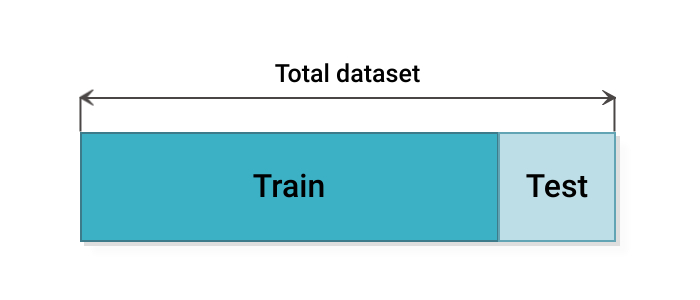

Вот последовательность действия в этом случае валидации:

1. Делим датасет на тренировочную и тестовыю выборки. Обычно делят в соотношении 80/20, но всё зависит от задачи
2. Тренируем модель на тренировочном датасете
3. Валидируем/оцениваем на тестовом множестве
4. Сохраняем результат

In [5]:
import numpy as np

from sklearn.model_selection import train_test_split 

X, y = np.arange(1000).reshape((100, 10)), np.arange(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train)/len(X))


0.8


train_test_split автоматически перемешивает данные, чтобы не было такой ситуации, как 800 собак - в тренировочной выборке, а 200 кошек - в тестовой. Модель просто не научится классифицировать кошек

**Минусы hold-out**

Тем не менее, Hold-out имеет серьезный недостаток. 

Например, набор данных, который не является полностью равномерным с точки зрения распределения. Если это так, мы можем оказаться в затруднительном положении после разделения. Например, обучающий набор не будет представлять тестовый набор. Как обучающие, так и тестовые данные могут сильно отличаться, один из них может быть проще или сложнее. 

Более того, тот факт, что мы тестируем нашу модель только один раз, может быть узким местом для этого метода. По причинам, упомянутым ранее, результаты, полученные с помощью hold-out, могут быть неточными.

### **Стратификация**

Говоря об особенностях разбиения данных следует упомянуть о стратификации (stratification). 

Допустим, у нас есть сбалансированный датасет:

 Setosa - 33.3%
 Versicolor - 33.3%
 Virginica - 33.3%

И мы разбиваем его на треин/тест выборку 

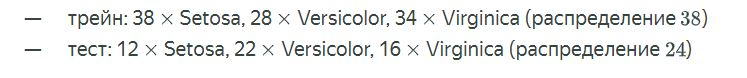

Если распределение цветов в исходном датасете отражает то, что в природе они встречаются одинаково часто, то мы только что получили два новых датасета, не соответствующих распределению цветов в природе. Распределения обоих датасетов вышли не только несбалансированными, но ещё и разными: самый частый класс в трейне соответствует наименее частому классу в тесте.

На помощь в такой ситуации может прийти стратификация: разбиение на трейн и тест, сохраняющее соотношение классов, представленное в исходном датасете. В sklearn такое разбиение можно получить с помощью параметра stratify:

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42,
#     stratify=y
# )

Если у вас очень несбалансированные данные, в которых один класс встречается сильно чаще другого (как, например, в задачах фильтрации спама или сегментации осадков на спутниковых снимках), стратификация может довольно сильно помочь.

### **2. k-Fold**


K-Fold перекрестная проверка — это метод, который минимизирует недостатки прошлого метода. K-Fold вводит новый способ разделения набора данных.

Алгоритм техники K-Fold:

1. Выберите число блоков - k. Обычно k равно 5 или 10, но вы можете выбрать любое число, которое меньше длины набора данных.
2. Разделите набор данных на k равных (при возможности) частей (они называются фолдами).
3. Выберите k - 1 блоков в качестве обучающего набора. Оставшийся блок будет тестовым набором.
4. Обучите модель на обучающем наборе. На каждой итерации перекрестной проверки вы должны обучить новую модель независимо от модели, обученной на предыдущей итерации.
5. Проверьте модель на тестовом наборе.
6. Сохраните результат проверки.
7. Повторите шаги 3-6 k раз. Каждый раз используйте оставшийся блок в качестве тестового набора. В конце концов вы должны проверить модель на каждом блоке.
8. Чтобы получить окончательный балл, усредните результаты, полученные на шаге 6.

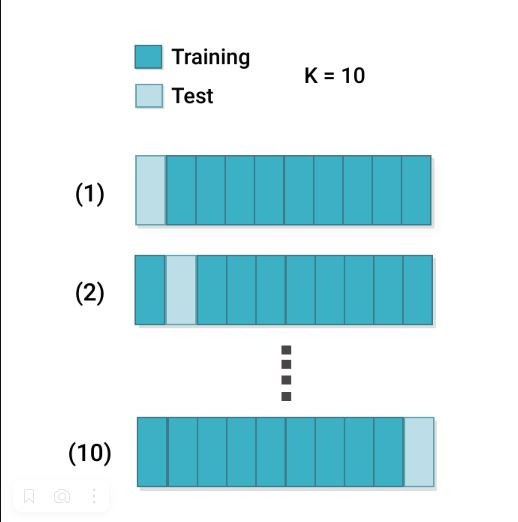

После применения k-Fold для одной модели у нас будет k экземпляров этой модели, обученных на разных подмножествах. Возможные варианты:

* делать предсказание с помощью усреднения предсказаний этих инстансов
* из этих инстансов выбрать тот, который набрал лучший скор на своём тестовом фолде, и применять дальше его
* заново обучить модель уже на всех k фолдах и делать предсказания уже этой моделью

Выбирать, какой способ лучше, нужно в зависимости от конкретной задачи и имеющихся вычислительных возможностей.

Метод k-Fold даёт более надёжную оценку качества модели, чем hold-out, так как обучение и тест модели происходят на разных подмножествах исходного датасета. Однако проведение k итераций обучения и теста может быть вычислительно затратным, и поэтому метод обычно применяют либо когда данных достаточно мало, либо при наличии большого количества вычислительных ресурсов, позволяющих проводить все k итераций параллельно. В реальных задачах данных зачастую достаточно много для того, чтобы hold-out давал хорошую оценку качества модели, поэтому k-Fold в больших задачах применяется не очень часто.

**Минусы k-Fold**

Вычислительно затратен

### **3. Leave-one-out**

Leave-One-Out Cross-Validation (LOOCV) - это частный случай перекрестной проверки k-Fold. Представьте, что k равно n, где n - количество образцов в наборе данных. 

Такой случай k-Fold эквивалентен технике Leave-One-Out.

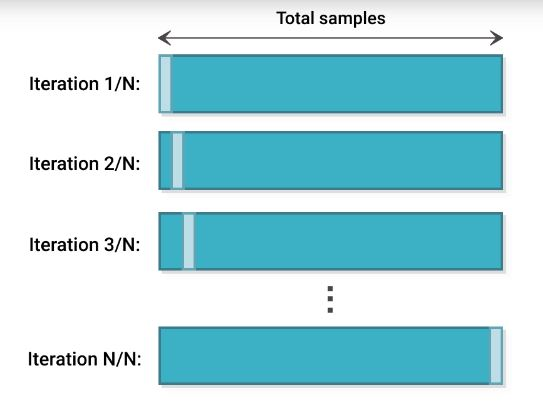

Алгоритм техники LOOCV:

1. Выберите один образец из набора данных, который будет тестовым набором.
2. Оставшиеся n - 1 образцов будут обучающим набором.
3. Обучите модель на обучающем наборе. На каждой итерации необходимо обучить новую модель.
4. Проверьте модель на тестовом наборе.
5. Сохраните результат проверки.
6. Повторите шаги 1-5 n раз, так как для n образцов у нас есть n различных обучающих и тестовых наборов.
7. Чтобы получить окончательный балл, усредните результаты, полученные на шаге 5.

In [7]:
import numpy as np
from sklearn.model_selection import LeaveOneOut

X = np.array([[1, 2], [3, 4], [5, 6]])
y = np.array([1, 2, 3])
loo = LeaveOneOut()

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 2] TEST: [0]
TRAIN: [0 2] TEST: [1]
TRAIN: [0 1] TEST: [2]


Наибольшим преимуществом перекрестной проверки (Leave-One-Out Cross-Validation, LOOCV) является то, что она максимально использует доступные данные. Мы используем только один образец из всего набора данных в качестве тестового набора, в то время как остальные служат обучающим набором. Однако по сравнению с k-Fold CV, LOOCV требует построения n моделей вместо k моделей, когда мы знаем, что n, которое представляет собой количество образцов в наборе данных, гораздо больше, чем k. Это означает, что LOOCV более вычислительно затратна, и может потребовать много времени для проверки модели с использованием LOOCV.

Таким образом, в сообществе данных есть общее правило, основанное на эмпирических данных и различных исследованиях, которое предполагает, что предпочтительнее использовать перекрестную проверку с 5 или 10 блоками вместо LOOCV.

**Минусы LOO**

Ещё более вычислительно затратен

### **4. Stratified k-Fold cross-validation**

Stratified k-Fold - это вариант стандартной техники кросс-валидации k-Fold, который разработан для эффективной работы в случаях дисбаланса целевого значения в наборе данных.

Алгоритм техники Stratified k-Fold следующий:

1. Выберите количество блоков - k.
2. Разделите набор данных на k блоков так, чтобы каждый блок содержал примерно тот же процент образцов каждого класса целевого значения, что и в полном наборе данных.
3. Выберите k - 1 блоков в качестве обучающего набора. Оставшийся блок будет тестовым набором.
4. Обучите модель на обучающем наборе. На каждой итерации необходимо обучить новую модель.
5. Проверьте модель на тестовом наборе.
6. Сохраните результат проверки.
7. Повторите шаги 3-6 k раз. Каждый раз используйте оставшийся блок в качестве тестового набора. В конце концов, вы должны проверить модель на каждом блоке.
8. Чтобы получить окончательный балл, усредните результаты, полученные на шаге 6.

Таким образом, Stratified k-Fold обеспечивает равномерное представление различных классов целевого значения в каждом блоке, что делает его более эффективным в случаях дисбаланса классов.

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


### **5. Time-series cross-validation**

Существует такая задача, как прогнозирование временных рядов. На практике она часто возникает в форме «Что будет с показателями нашего продукта в ближайший день / месяц / год?». При этом имеются какие-то исторические данные этих показателей за предыдущее время, которые можно визуализировать в виде некоторого графика по времени:

Кросс-валидация моделей для такой задачи осложняется тем, что данные не должны пересекаться по времени: тренировочные данные должны идти до валидационных, а валидационные — до тестовых. С учётом этих особенностей фолды в кросс-валидации для временных рядов располагаются вдоль временной оси так, как показано на следующей картинке:

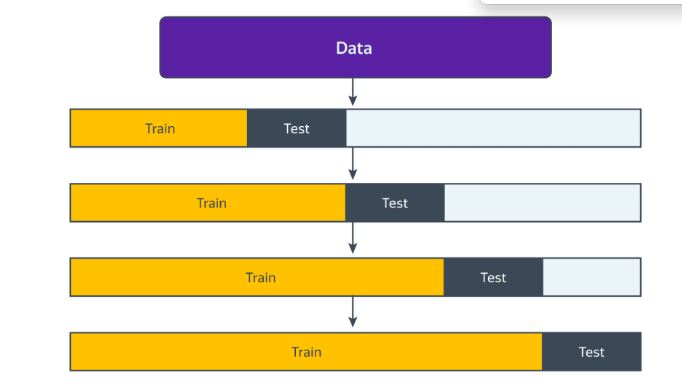

In [9]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
 
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


## **Имплементация k-Fold**

Алгоритм техники K-Fold:

1. Выберите число блоков - k. Обычно k равно 5 или 10, но вы можете выбрать любое число, которое меньше длины набора данных.
2. Разделите набор данных на k равных (при возможности) частей (они называются фолдами).
3. Выберите k - 1 блоков в качестве обучающего набора. Оставшийся блок будет тестовым набором.
4. Обучите модель на обучающем наборе. На каждой итерации перекрестной проверки вы должны обучить новую модель независимо от модели, обученной на предыдущей итерации.
5. Проверьте модель на тестовом наборе.
6. Сохраните результат проверки.
7. Повторите шаги 3-6 k раз. Каждый раз используйте оставшийся блок в качестве тестового набора. В конце концов вы должны проверить модель на каждом блоке.
8. Чтобы получить окончательный балл, усредните результаты, полученные на шаге 6.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from copy import copy

In [11]:
def cool_cross_validation(model, X, y, k = 5):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)

    scores = []

    for i in range(k):
        X_test = X_folds[i]
        y_test = y_folds[i]
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
        model = copy(model) #модель, которую мы подаём не должна обучаться, мы её копируем и выводим результаты валидации, оставляя оригинал нетронутым.
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    return scores

## **Тестирование на датасете и сравнение с готовой реализацией из sklearn**

In [12]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../Datasets/Classification/train.csv')
X = df.drop(columns = 'price_range')
y = df['price_range']
knn = KNeighborsClassifier()

In [13]:
cv_results = cross_validate(knn, X, y, cv = 5)

In [14]:
cv_results

{'fit_time': array([0.00200129, 0.00199986, 0.00199938, 0.00300407, 0.00200057]),
 'score_time': array([0.12399864, 0.0249989 , 0.02100182, 0.02199411, 0.02200174]),
 'test_score': array([0.92  , 0.9175, 0.925 , 0.925 , 0.91  ])}

In [15]:
def show_cv_res(cv_results):    
    fig, ax = plt.subplots()
    bar_width = 0.7
    inds = np.arange(len(cv_results['test_score']))
    ax.bar(inds, cv_results['test_score'], bar_width, label = "Test Scores")
    ax.set_xlabel('Folds')
    ax.set_ylabel('Accuracy')
    plt.show()
    print(cv_results['test_score'])

def show_cool_cv_res(cv_results):    
    fig, ax = plt.subplots()
    bar_width = 0.7
    inds = np.arange(len(cv_results))
    ax.bar(inds, cv_results, bar_width, label = "Test Scores")
    ax.set_xlabel('Folds')
    ax.set_ylabel('Accuracy')
    plt.show()
    print(cv_results)

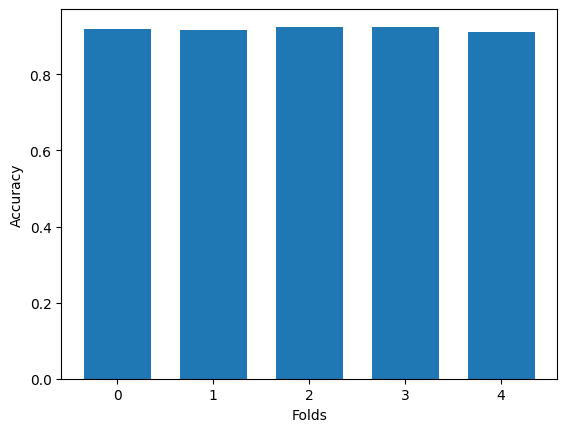

[0.92   0.9175 0.925  0.925  0.91  ]


In [16]:
show_cv_res(cv_results) #sklearnовская кросс-валидация

c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature nam

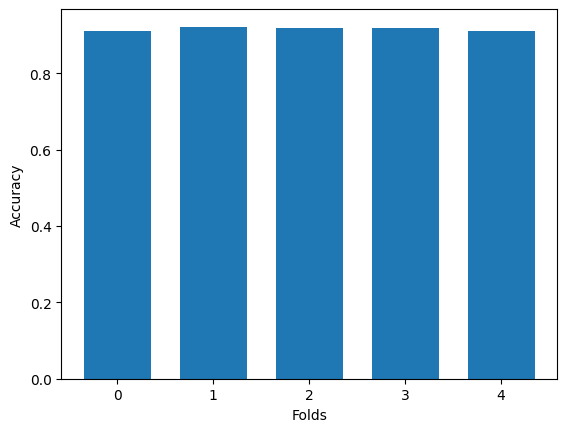

[0.9125, 0.9225, 0.92, 0.92, 0.91]


In [17]:
our_results = cool_cross_validation(knn, X, y, k=5)
show_cool_cv_res(our_results)

In [18]:
print(our_results)

[0.9125, 0.9225, 0.92, 0.92, 0.91]


In [19]:
print(cv_results['test_score'])

[0.92   0.9175 0.925  0.925  0.91  ]


Графики очень похожи, но метрики на, по идее, одних и тех же фолдах отличаются. Можно предположить, что sklearn как-то перемешивает данные,чего не предусмотрено в моей имплементации, поэтому и рещультаты отличаются

## **Что такое Grid Search и подбор гиперпараметров, зачем он нужен**

У любой модели машииного и глубокого обучения существует набор параметров и гиперпараметров. Это разные понятия и их обязательно нужно уметь различать:

1) **Параметры** настраиваются в процессе обучения модели на данных. Например, веса в линейной регрессии, нейросетях, структура решающего дерева;
2) **Гиперпараметры** — это характеристики модели, которые фиксируются до начала обучения: глубина решающего дерева, количество соседей, значение силы регуляризации в линейной модели, learning rate для градиентного спуска.

То есть параметры поддаются влияюнию данных и подстраиваются под них, а ответственность за гиперпараметры лежит на нас. Данные никак не влияют на гиперпараметры, зато они влияют на то, какой будет резкльтат работы модели с этими данными, поэтому уметь подбирать их необходимо.


Подбор гиперпараметров подразумевает разбиения выборки на 3 части: на тренировочную, **валидационную** и тестовую. На валидационной как раз и будет происходить подбор.

Разделения только на тренировочную и тестовую выборки недостаточно, так как в модель через подобранные гиперпараметры просачивается информация о тестовой выборке. Это означает, что на новых данных модели могут не сохранить свои качества и что их сравнение не будет точным.

Если оптимизировать гиперпараметры моделей и проводить их сравнение на одном и том же множестве, то можно неявно заложить в модели информацию о тестовом множестве и получить результаты хуже ожидаемых на новых данных. То есть мы подстраиваем гиперпараметры, основываясь на результатах оценивания на тестовой выборке, которая чаще всего не охватывает генеральную совокупность данных.

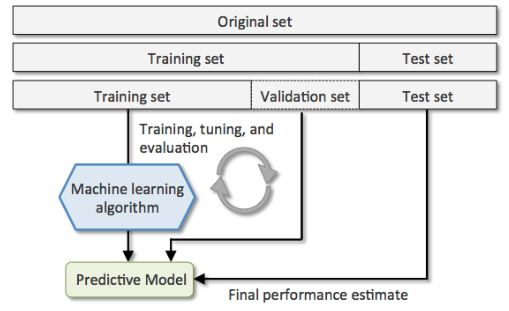

Также можно провести кросс-валидацию, но перед ней разбить множестов на тестовою и тренировочную выборку. Мы не создаем валидационную, а проводим кросс-валидацию на тренировочной для подбора гиперпармаетров. Такой способ применяется, если данных мало и жертвовать ими для валидации неприемлемо.

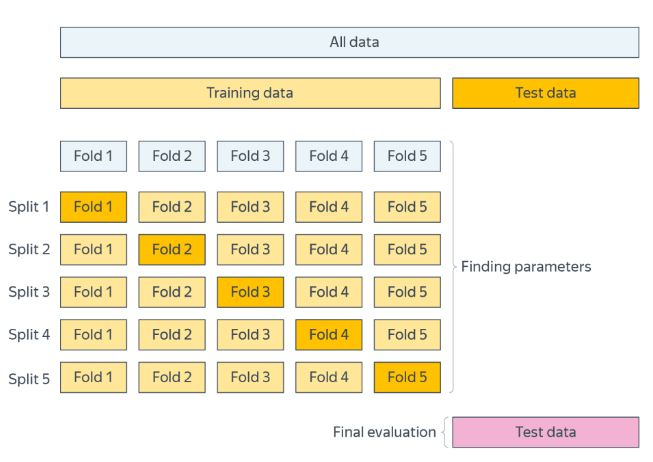

Мы поговорили о том, как работать с данными для подбора гиперпараметров, зачем они нужны, но так и не упомянули, как это делать. 

Есть много способов подбирать гиперпараметры: Grid Search, Random Search, Exploration vs exploitation, Байесовская оптимизация, Tree-structured Parzen Estimator, Population Based Training и т.д

Но основным, самым поаулярным и простым остается Grid Search. Его то мы и разберём

**Вот как он работает:**
1. Для каждого гиперпараметра фиксируется несколько значений;
2. Перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
3. Выбирается комбинация, на которой модель показывает лучшее качество.

Допустим, мы выбрали M гиперпараметров и для каждого задали N возможных значений, тогда количество вариантов будет N^M, то есть мы такое кол-во раз должны обучить и оценить модель. Если мы используем кросс-валидацию, то это число надо умножить на число фолдов.

Перебор некоторых значений гиперпараметров можно вести по логарифмической шкале, так как это позволяет быстрее определить правильный порядок параметра и в то же время значительно уменьшить время поиска. Так можно подбирать, например, значение learning rate для градиентного спуска, значение константы регуляризации для линейной регрессии или метода SVM.

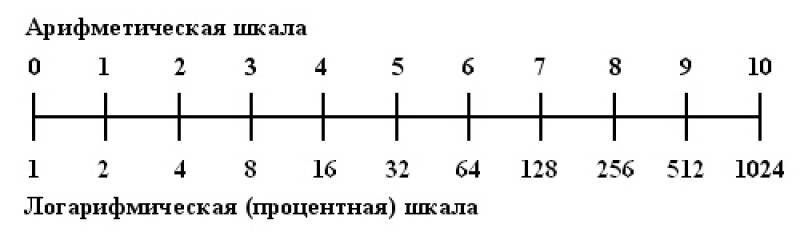

**Минусы Grid Search**

Сразу видно, что если M и N большие, а модель обучается/тестируется долго, подбор гиперпараметров таким способом займет неразумное количество времени.

## **Реализация Grid Search**

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [21]:
res = cross_validate(rf, X, y)

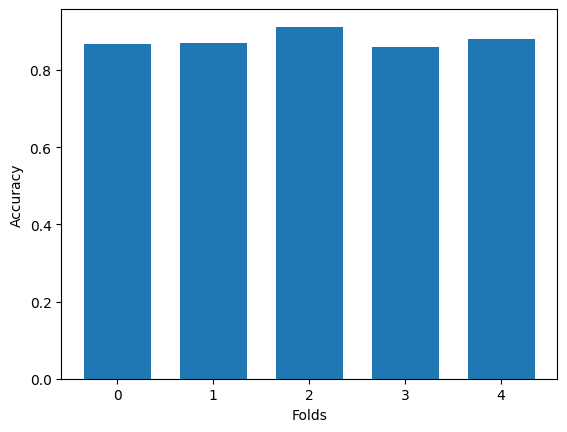

[0.8675 0.87   0.9125 0.86   0.88  ]


In [22]:
show_cv_res(res)

In [23]:
#Пусть у нас есть модель-классификатор Случайный Лес. И нам нужно перебрать его гиперпараметры, вывести лучшие для нашего датасета df

grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
           }

In [63]:
import itertools

def grid_search(model, grid_space, X, y):
    best_score = -1
    best_params = None
    best_model = None

    combinations = itertools.product(*grid_space.values()) #Все возможные комбинации гиперпараметров. Это и есть сетка (grid)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = copy(model)

    for comination in combinations:
        for key, val in zip(grid_space.keys(), comination):
            setattr(model, key, val)
        
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_model = model
            best_params = dict(zip(grid_space.keys(), comination))
    
    return best_score, best_params, best_model

In [77]:
def grid_search_cross_validation(model, grid_space, X, y, k_folds):
    model = copy(model)
    combinations = itertools.product(*grid_space.values())

    best_params = None
    best_score = -1

    for params in combinations:
        for key, val in zip(grid_space.keys(), params):
            setattr(model, key, val)
        mean_score = np.mean(cool_cross_validation(model, X,y, k_folds))
        if mean_score > best_score:
            best_score = mean_score
            best_params = dict(zip(grid_space.keys(), params))
    return best_score, best_params

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
grid = GridSearchCV(rf, param_grid=grid_space, cv=5, scoring='accuracy')
model_grid = grid.fit(X,y)

In [28]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': None, 'max_features': 7, 'n_estimators': 100}
Best score is: 0.8955


In [29]:
best_score, best_params, best_model = grid_search(rf, grid_space, X, y)

In [30]:
print('Best hyperparameters are: '+str(best_params))
print('Best score is: '+str(best_score))

Best hyperparameters are: {'max_depth': None, 'n_estimators': 100, 'max_features': 7}
Best score is: 0.89


In [78]:
best_score, best_params = grid_search_cross_validation(rf, grid_space, X, y, k_folds=5)

c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without f

In [79]:
print('Best hyperparameters are: '+str(best_params))
print('Best score is: '+str(best_score))

Best hyperparameters are: {'max_depth': 10, 'n_estimators': 200, 'max_features': 7}
Best score is: 0.8955
